<a href="https://colab.research.google.com/github/jonatanbarkan/ACEDeep/blob/master/ADCEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
import tqdm
import pandas as pd
from collections import defaultdict

sns.set_style("whitegrid")


In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

In [ ]:
d = 3
num_samples = 10000

In [ ]:
mu = [0]*d
cov = np.eye(d)

In [ ]:
kind = 'hex'
# kind = 'scatter'

In [ ]:
Z = np.random.multivariate_normal(mu, cov, num_samples)
N1 = np.random.multivariate_normal(mu,  cov, num_samples)
N2 = np.random.multivariate_normal(mu,  cov, num_samples)

In [539]:
X = Z + 1.1 * N1
Y = Z + 1.1 * N2

In [540]:
def draw_correlations(A, B, plot=True):
  for i in range(A.shape[-1]):
    print(f'correlations {i}th entry: {np.corrcoef(A[:,i], B[:,i])[0,1]}')
    if plot:
      sns.jointplot(A[:, i], B[:, i], kind=kind)

correlations 0th entry: 0.44558386250363874
correlations 1th entry: 0.4424084725661926
correlations 2th entry: 0.474830356844105


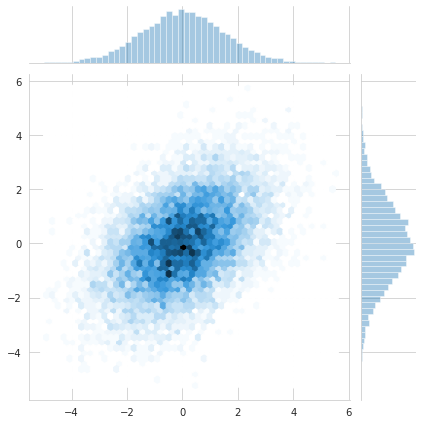

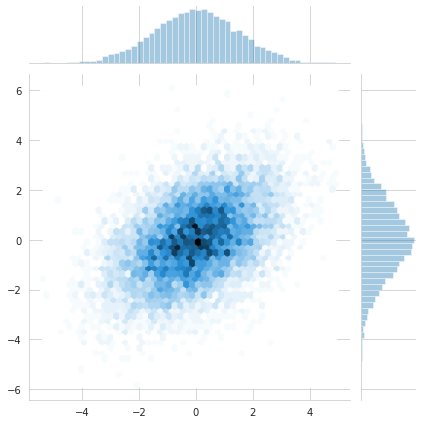

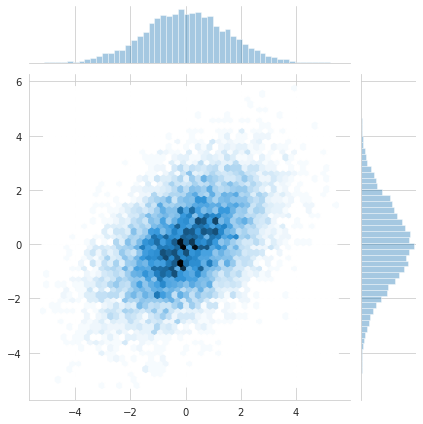

In [541]:
draw_correlations(X, Y)

In [ ]:
thetaX = [0] * d
thetaX[2] = np.pi/3
rot_axis_X = np.array([1, 1, 1])
rotX = Rotation.from_rotvec(thetaX * rot_axis_X)
X = rotX.apply(X)

In [ ]:
print(f'X: mean {np.mean(X, axis=0)}, std {np.std(X, axis=0)}')

In [ ]:
thetaY = [0] * d
thetaY[0] = -np.pi / 2
thetaY[1] = -np.pi / 6
rot_axis_Y = np.array([1, 1, 1])
rotY = Rotation.from_rotvec(thetaY * rot_axis_Y)
Y = rotY.apply(Y)

In [ ]:
print(f'X: mean {np.mean(Y, axis=0)}, std {np.std(Y, axis=0)}')

$X, Y$ are rotations of a linear combination of $Z + \lambda N1$ and $Z + \lambda N2$ respectively, where $Z, N1, N2$ each drawn from a multivariate gaussian with 0 mean and unit covariance.
$\lambda=0.1$ and the rotations are different and are performed around different axes.

correlations 0th entry: 0.09055871497212864
correlations 1th entry: 0.1216580218899256
correlations 2th entry: -0.03661930593561633


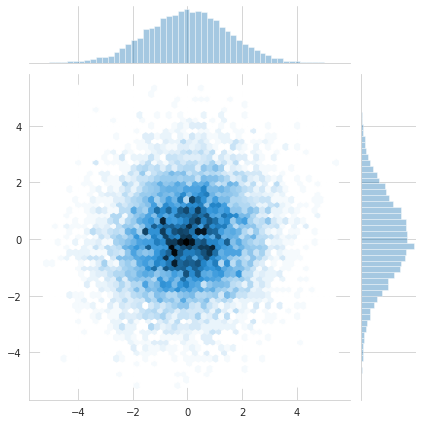

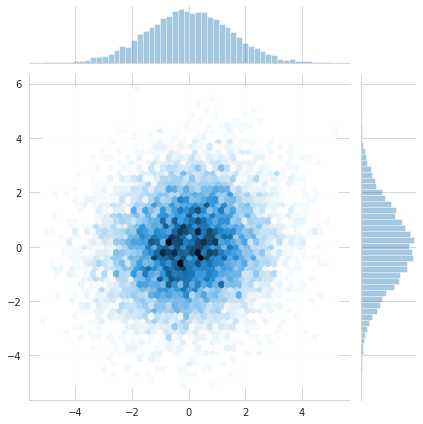

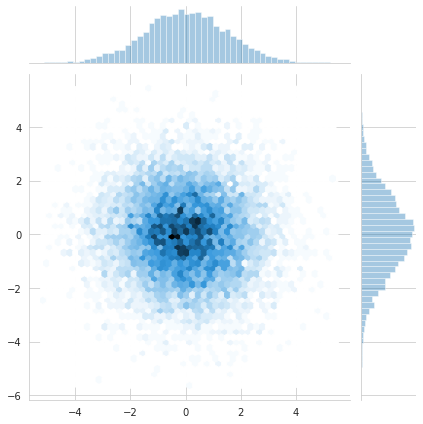

In [546]:
draw_correlations(X,Y)

### create pytorch model class and train and eval functions

notice there is no normalization at the final output. Normalization is performed with apply_transform function

In [ ]:
class Model(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, lr=0.01, activation=None):
      super(Model, self).__init__()
      self.fc1 = nn.Linear(input_size, hidden_size)
      # nn.init.xavier_normal_(self.fc1.weight)
      self.bn1 = nn.BatchNorm1d(num_features=hidden_size)
      self.fc2 = nn.Linear(hidden_size, output_size)
      # nn.init.xavier_normal_(self.fc2.weight)
      self.bn2 = nn.BatchNorm1d(num_features=output_size, )
      
      self.learning_rate = lr
      self._criterion = nn.MSELoss()
      self._optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
      self.activation = activation
      
  def forward(self, x, activation=None):
      u = self.fc1(x)
      u = self.bn1(u)
      if self.activation is not None:
        u = self.activation(u)
      u = self.fc2(u)
      return u
    
  def get_criterion(self):
      return self._criterion

  def get_optimizer(self):
      return self._optimizer
  

In [ ]:
def make_train_step(model):
    # Builds function that performs a step in the train loop
    loss_fn = model.get_criterion()
    optimizer = model.get_optimizer()
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

In [ ]:
def make_eval_step(model):
    # Builds function that performs a step in the train loop
    loss_fn = model.get_criterion()
    def eval_step(x, y):
        # Sets model to TRAIN mode
        model.eval()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return eval_step

In [ ]:
def apply_transform(model, inp, zero_mean=True, unit_var=True):
  model.eval()
  out = model(inp)
  if zero_mean:
    out -= out.mean(axis=0)
  if unit_var:
    out = torch.div(out, out.std(axis=0))
  return out

### create data

In [ ]:
x_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(Y).float()

In [552]:
from sklearn.model_selection import train_test_split

In [553]:
X_train, X_test, Y_train, Y_test = train_test_split(x_tensor, y_tensor, test_size=0.33, random_state=42)

In [554]:
# X_train -= X_train.mean(axis=0)
# X_train /= X_train.std(axis=0)
# Y_train -= Y_train.mean(axis=0)
# Y_train /= Y_train.std(axis=0)

In [555]:
X_train.std(axis=0)

tensor([1.4815, 1.4920, 1.4878])

In [556]:
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_test, Y_test)

In [ ]:
# train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

Find linear CCA result for wanted dim

In [558]:
wanted_dim = 1

X_c: mean [ 0.00672653 -0.01162446  0.0406341 ], std [0.98964734 0.99406142 0.98254769]
Y_c: mean [-0.00082604 -0.0043771   0.04834826], std [1.01135556 0.99249745 0.98131162]
correlations 0th entry: 0.46266818692765094
correlations 1th entry: 0.45041337752746996
correlations 2th entry: 0.42162116892090024


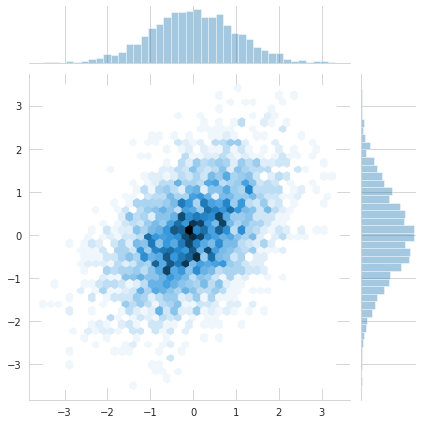

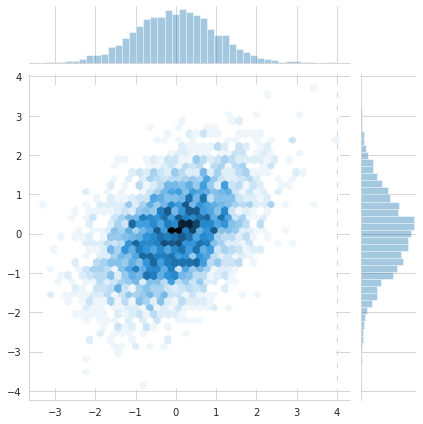

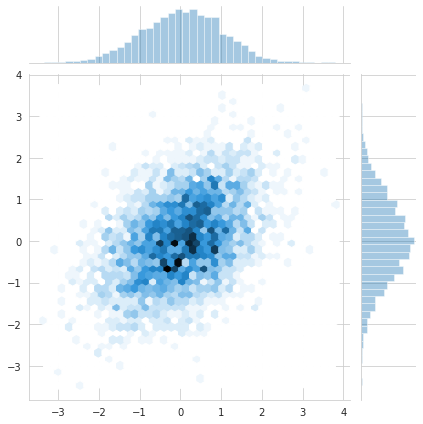

In [559]:
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=3)
cca.fit(X_train, Y_train)
X_c, Y_c = cca.transform(X_test, Y_test)
print(f'X_c: mean {np.mean(X_c, axis=0)}, std {np.std(X_c, axis=0)}')
print(f'Y_c: mean {np.mean(Y_c, axis=0)}, std {np.std(Y_c, axis=0)}')

draw_correlations(X_c, Y_c)

### Run ACE

In [560]:
def learn(loader, _x_model, _y_model, _max_samples=np.inf):
  U = []
  V = []
  losses_x = []
  losses_y = []

  sample_count = 0
  for x_batch, y_batch in loader:
    sample_count += len(x_batch)
    if sample_count > _max_samples:
      break
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    transformed_y_batch = apply_transform(_y_model, y_batch)
    loss_x = x_train_step(x_batch, transformed_y_batch)
    losses_x.append(loss_x)

    transformed_x_batch = apply_transform(_x_model, x_batch)
    loss_y = y_train_step(y_batch, transformed_x_batch)
    losses_y.append(loss_y)

    U.append(apply_transform(_y_model, y_batch))
    V.append(transformed_y_batch)
  U = torch.cat(U)
  V = torch.cat(V)
  UV = U * V

  return UV.mean(axis=0).item(), np.mean(losses_x), np.mean(losses_y)


In [561]:
def evaluate(loader, _x_model, _y_model):
  U = []
  V = []
  val_loss_x = []
  val_loss_y = []
  with torch.no_grad(): 
    for x_val, y_val in loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)

      transformed_y_batch = apply_transform(_y_model, y_val)
      transformed_x_batch = apply_transform(_x_model, x_val)

      U.append(transformed_x_batch)
      V.append(transformed_y_batch)

      val_loss_x.append(x_eval_step(x_val, transformed_y_batch))
      val_loss_y.append(y_eval_step(y_val, transformed_x_batch))
  U = torch.cat(U)
  V = torch.cat(V)
  UV = U * V
  draw_correlations(U, V, False)
  return UV.mean(axis=0).item(), np.mean(val_loss_x), np.mean(val_loss_y)


In [ ]:
hidden_size = 3
max_epochs = 10
lr = 0.01
act = None
# act = F.relu
# batch_size = len(train_dataset) // 2
batch_size = 32

In [591]:
max_samples = len(train_dataset) // 100

In [592]:
max_samples

67

In [593]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)

In [ ]:
x_model = Model(X.shape[-1], hidden_size, wanted_dim, lr=lr, activation=act)
y_model = Model(Y.shape[-1], hidden_size, wanted_dim, lr=lr, activation=act)

steps = []
epochs = []

x_train_step = make_train_step(x_model)
y_train_step = make_train_step(y_model)

x_eval_step = make_eval_step(x_model)
y_eval_step = make_eval_step(y_model)

training_scores = defaultdict(list)

validation_scores = defaultdict(list)
last_score, loss_x, loss_y = evaluate(val_loader, x_model, y_model)
validation_scores['validation_scores'].append(last_score)
validation_scores['x_model_error'].append(loss_x)
validation_scores['y_model_error'].append(loss_y)
validation_scores['epoch'].append(-1)

i = 0
ep = 0

for epoch in range(max_epochs):
  # train
  train_score, train_x_loss, train_y_loss = learn(train_loader, x_model, y_model, _max_samples=max_samples)
  training_scores['training_scores'].append(train_score)
  training_scores['x_model_error'].append(train_x_loss)
  training_scores['y_model_error'].append(train_y_loss)
  training_scores['epoch'].append(epoch)

  # validate
  current_score, val_x_loss, val_y_loss = evaluate(val_loader, x_model, y_model)
  validation_scores['validation_scores'].append(current_score)
  validation_scores['x_model_error'].append(val_x_loss)
  validation_scores['y_model_error'].append(val_y_loss)
  validation_scores['epoch'].append(epoch)

  # if last_score > current_score:
  #   break
  last_score = current_score
        

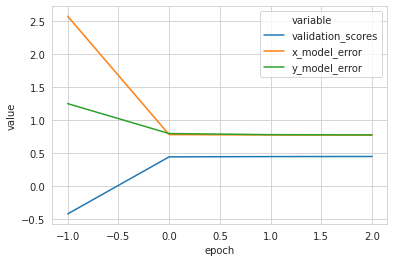

In [567]:
validation_data = pd.DataFrame(validation_scores)
df_val = pd.melt(validation_data, 'epoch')
sns.lineplot('epoch', 'value', 'variable', data=df_val)

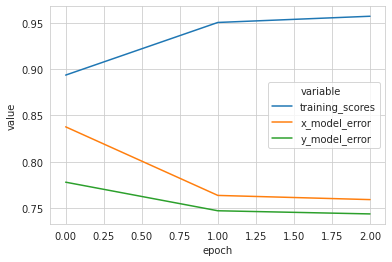

In [568]:
training_data = pd.DataFrame(training_scores)
df_train = pd.melt(training_data, 'epoch')
sns.lineplot('epoch', 'value', 'variable', data=df_train)

In [569]:
def learn_orthogonal_initialization(loader, previous_models, new_model):
  # U = []
  # V = []
  # losses_x = []
  # losses_y = []
  for _, y_batch in loader:
    # x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    for model in previous_models:
      transformed_batch = apply_transform(model, y_batch)
    loss_x = x_train_step(x_batch, transformed_y_batch)
    losses_x.append(loss_x)

    transformed_x_batch = apply_transform(_x_model, x_batch)
    loss_y = y_train_step(y_batch, transformed_x_batch)
    losses_y.append(loss_y)

    U.append(apply_transform(_y_model, y_batch))
    V.append(transformed_y_batch)
  U = torch.cat(U)
  V = torch.cat(V)
  UV = U * V

  return UV.mean(axis=0).item(), np.mean(losses_x), np.mean(losses_y)
